In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Menetapkan device (GPU jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

Menggunakan device: cuda


# PERSIAPAN DATA

In [5]:
# Buat DataFrame
df = pd.read_csv("ReviewTokoBaju.csv")
df = df[['Review Text', 'Recommended IND']].dropna()
print(f"Jumlah data: {len(df)}")

Jumlah data: 22641


In [7]:
# Tokenisasi text
max_features = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Review Text'])
X = tokenizer.texts_to_sequences(df['Review Text'])
X = pad_sequences(X, maxlen=max_len, padding='post')
y = df['Recommended IND'].values

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Konversi ke tensor PyTorch
X_train = torch.tensor(X_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [10]:
# Dataset dan DataLoader
class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [11]:
# Buat dataset
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

In [12]:
# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# MODEL RNN

In [13]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        output, hidden = self.rnn(embedded)  # output: [batch_size, seq_len, hidden_dim*2]

        # Mengambil hidden state terakhir dari kedua arah
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # [batch_size, hidden_dim*2]
        hidden = self.dropout(hidden)

        return torch.sigmoid(self.fc(hidden)).squeeze()

# MODEL LSTM

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)

        # Menggabungkan hidden state terakhir dari kedua arah
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)

        return torch.sigmoid(self.fc(hidden)).squeeze()

# MODEL GRU

In [15]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)

        # Menggabungkan hidden state terakhir dari kedua arah
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)

        return torch.sigmoid(self.fc(hidden)).squeeze()

# FUNGSI PELATIHAN DAN EVALUASI

In [16]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    avg_loss = total_loss / len(train_loader)

    return accuracy, avg_loss

In [17]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    total_loss = 0

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            y_true.extend(labels.cpu().numpy())
            probs = outputs.cpu().numpy()
            y_prob.extend(probs)
            y_pred.extend((probs >= 0.5).astype(int))

    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    f1_squared = f1 ** 2

    # Hitung AUC-ROC hanya jika ada kedua kelas
    auc = 0
    if len(set(y_true)) > 1:
        auc = roc_auc_score(y_true, y_prob)

    avg_loss = total_loss / len(test_loader)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_squared': f1_squared,
        'auc': auc,
        'loss': avg_loss,
        'y_true': y_true,
        'y_prob': y_prob
    }

# FUNGSI VISUALISASI

In [18]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss, model_name):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [19]:
def plot_roc_curve(y_true, y_prob, model_name):
    if len(set(y_true)) > 1:  # Pastikan ada kedua kelas
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    else:
        print("Tidak dapat membuat ROC curve karena hanya ada satu kelas dalam data pengujian.")

# PELATIHAN MODEL

In [20]:
def train_and_evaluate(model_class, model_name, epochs=10):
    # Inisialisasi model
    vocab_size = len(tokenizer.word_index) + 1
    model = model_class(vocab_size=vocab_size,
                      embed_dim=128,
                      hidden_dim=128,
                      output_dim=1).to(device)

    # Loss dan optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Inisialisasi list untuk tracking metrik
    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    # Pelatihan model
    for epoch in range(epochs):
        # Training
        train_acc, train_loss = train_model(model, train_loader, criterion, optimizer, device)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        # Evaluasi
        eval_metrics = evaluate_model(model, test_loader, criterion, device)
        val_acc_list.append(eval_metrics['accuracy'])
        val_loss_list.append(eval_metrics['loss'])

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f}, Loss: {train_loss:.4f} | "
              f"Val Acc: {eval_metrics['accuracy']:.4f}, Loss: {eval_metrics['loss']:.4f}")

    # Evaluasi akhir
    final_metrics = evaluate_model(model, test_loader, criterion, device)

    # Print hasil akhir
    print(f"\n===== Hasil Evaluasi Model {model_name} =====")
    print(f"Accuracy: {final_metrics['accuracy']:.4f}")
    print(f"Precision: {final_metrics['precision']:.4f}")
    print(f"Recall: {final_metrics['recall']:.4f}")
    print(f"F1 Squared: {final_metrics['f1_squared']:.4f}")
    print(f"AUC: {final_metrics['auc']:.4f}")

    # Visualisasi
    plot_metrics(train_acc_list, val_acc_list, train_loss_list, val_loss_list, model_name)
    plot_roc_curve(final_metrics['y_true'], final_metrics['y_prob'], model_name)

    return model, final_metrics

# EKSEKUSI MODEL


Pelatihan Model RNN
Epoch 1/10 | Train Acc: 0.8171, Loss: 0.4393 | Val Acc: 0.8225, Loss: 0.4149
Epoch 2/10 | Train Acc: 0.8207, Loss: 0.4406 | Val Acc: 0.8271, Loss: 0.4261
Epoch 3/10 | Train Acc: 0.8262, Loss: 0.4111 | Val Acc: 0.8375, Loss: 0.3723
Epoch 4/10 | Train Acc: 0.8366, Loss: 0.3801 | Val Acc: 0.7980, Loss: 0.4049
Epoch 5/10 | Train Acc: 0.8518, Loss: 0.3437 | Val Acc: 0.8423, Loss: 0.3504
Epoch 6/10 | Train Acc: 0.8488, Loss: 0.3465 | Val Acc: 0.8379, Loss: 0.3614
Epoch 7/10 | Train Acc: 0.8328, Loss: 0.3907 | Val Acc: 0.8377, Loss: 0.3869
Epoch 8/10 | Train Acc: 0.8410, Loss: 0.3698 | Val Acc: 0.8236, Loss: 0.3931
Epoch 9/10 | Train Acc: 0.8577, Loss: 0.3243 | Val Acc: 0.8594, Loss: 0.3181
Epoch 10/10 | Train Acc: 0.8530, Loss: 0.3341 | Val Acc: 0.8485, Loss: 0.3485

===== Hasil Evaluasi Model RNN =====
Accuracy: 0.8485
Precision: 0.9008
Recall: 0.9163
F1 Squared: 0.8254
AUC: 0.8577


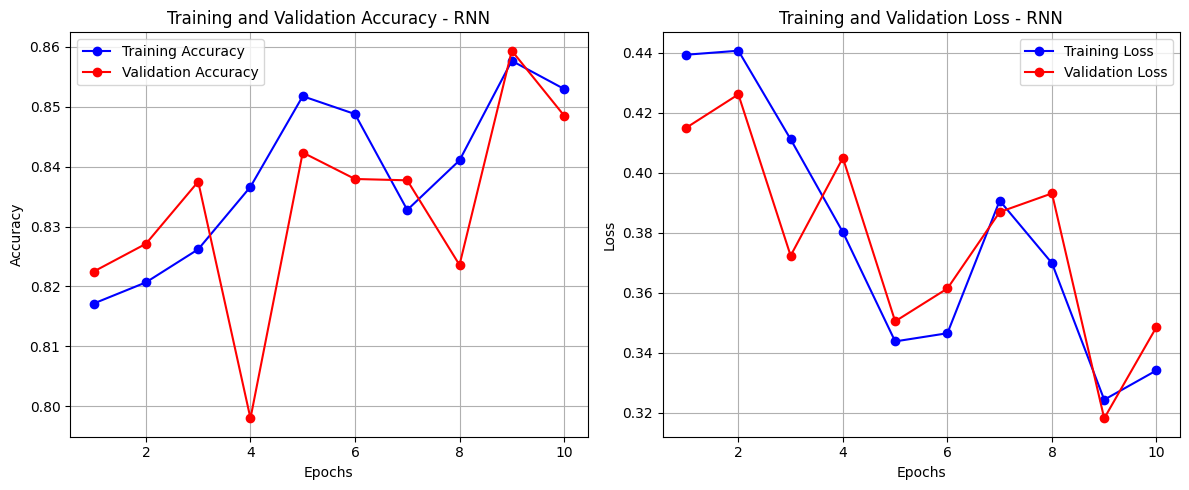

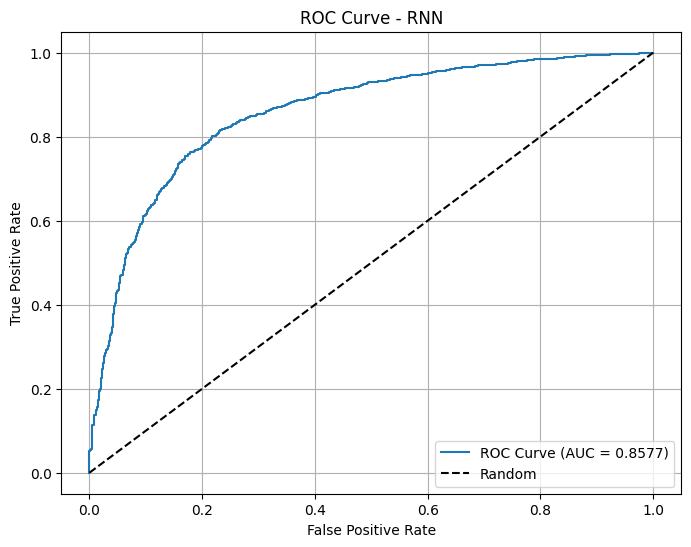

In [21]:
# RNN
print("\n" + "="*50)
print("Pelatihan Model RNN")
print("="*50)
rnn_model, rnn_metrics = train_and_evaluate(RNNModel, "RNN", epochs=10)


Pelatihan Model LSTM
Epoch 1/10 | Train Acc: 0.8303, Loss: 0.4086 | Val Acc: 0.8417, Loss: 0.3647
Epoch 2/10 | Train Acc: 0.8601, Loss: 0.3216 | Val Acc: 0.8655, Loss: 0.2981
Epoch 3/10 | Train Acc: 0.8918, Loss: 0.2591 | Val Acc: 0.8803, Loss: 0.2610
Epoch 4/10 | Train Acc: 0.9133, Loss: 0.2185 | Val Acc: 0.8861, Loss: 0.2624
Epoch 5/10 | Train Acc: 0.9263, Loss: 0.1854 | Val Acc: 0.8900, Loss: 0.2637
Epoch 6/10 | Train Acc: 0.9395, Loss: 0.1569 | Val Acc: 0.8892, Loss: 0.2614
Epoch 7/10 | Train Acc: 0.9491, Loss: 0.1347 | Val Acc: 0.8870, Loss: 0.2831
Epoch 8/10 | Train Acc: 0.9609, Loss: 0.1059 | Val Acc: 0.8881, Loss: 0.3102
Epoch 9/10 | Train Acc: 0.9658, Loss: 0.0930 | Val Acc: 0.8841, Loss: 0.3634
Epoch 10/10 | Train Acc: 0.9752, Loss: 0.0714 | Val Acc: 0.8870, Loss: 0.3748

===== Hasil Evaluasi Model LSTM =====
Accuracy: 0.8870
Precision: 0.9274
Recall: 0.9354
F1 Squared: 0.8675
AUC: 0.9238


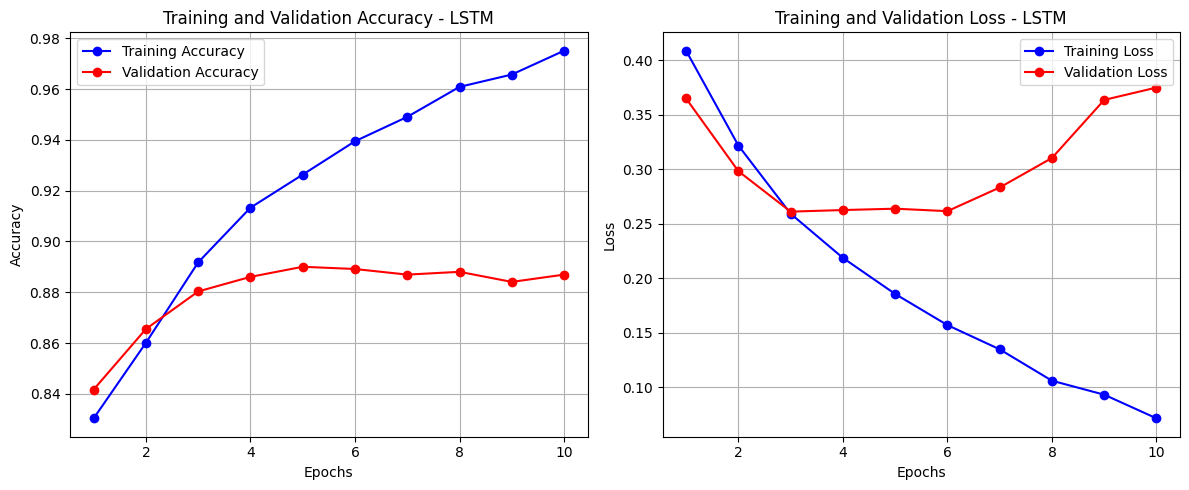

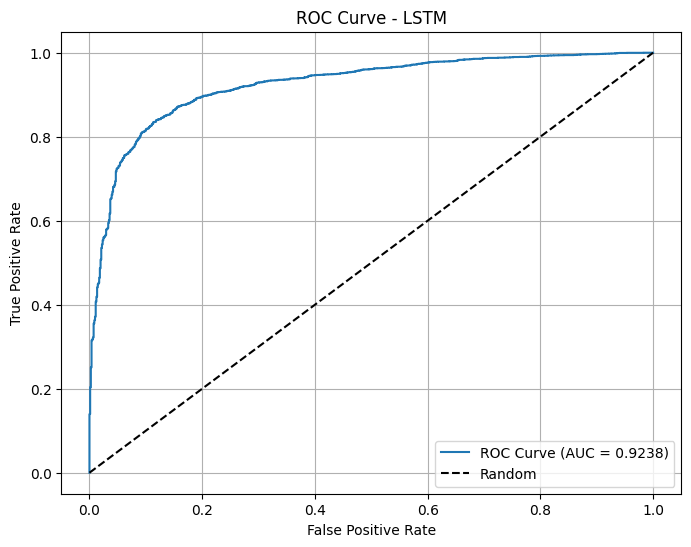

In [22]:
# LSTM
print("\n" + "="*50)
print("Pelatihan Model LSTM")
print("="*50)
lstm_model, lstm_metrics = train_and_evaluate(LSTMModel, "LSTM", epochs=10)


Pelatihan Model GRU
Epoch 1/10 | Train Acc: 0.8327, Loss: 0.3853 | Val Acc: 0.8635, Loss: 0.3171
Epoch 2/10 | Train Acc: 0.8793, Loss: 0.2886 | Val Acc: 0.8892, Loss: 0.2569
Epoch 3/10 | Train Acc: 0.9091, Loss: 0.2248 | Val Acc: 0.8863, Loss: 0.2517
Epoch 4/10 | Train Acc: 0.9282, Loss: 0.1826 | Val Acc: 0.8969, Loss: 0.2533
Epoch 5/10 | Train Acc: 0.9454, Loss: 0.1406 | Val Acc: 0.8920, Loss: 0.2699
Epoch 6/10 | Train Acc: 0.9621, Loss: 0.1064 | Val Acc: 0.8980, Loss: 0.2952
Epoch 7/10 | Train Acc: 0.9732, Loss: 0.0782 | Val Acc: 0.8942, Loss: 0.3214
Epoch 8/10 | Train Acc: 0.9786, Loss: 0.0618 | Val Acc: 0.8956, Loss: 0.3466
Epoch 9/10 | Train Acc: 0.9873, Loss: 0.0378 | Val Acc: 0.8920, Loss: 0.3842
Epoch 10/10 | Train Acc: 0.9882, Loss: 0.0352 | Val Acc: 0.8900, Loss: 0.4141

===== Hasil Evaluasi Model GRU =====
Accuracy: 0.8900
Precision: 0.9396
Recall: 0.9255
F1 Squared: 0.8696
AUC: 0.9242


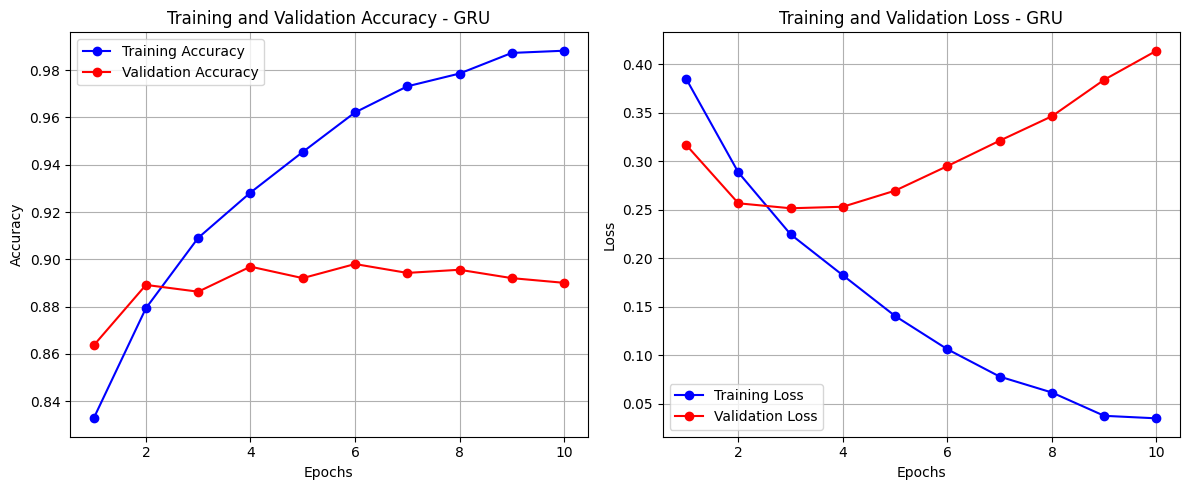

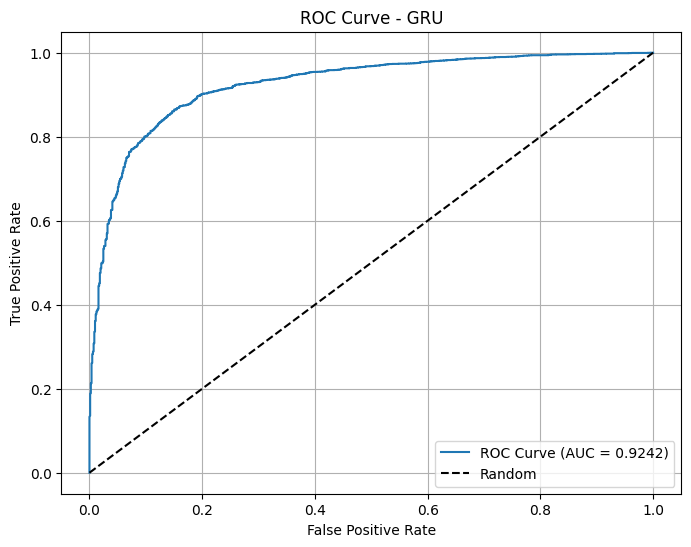

In [23]:
# GRU
print("\n" + "="*50)
print("Pelatihan Model GRU")
print("="*50)
gru_model, gru_metrics = train_and_evaluate(GRUModel, "GRU", epochs=10)

# PERBANDINGAN MODEL

In [24]:
models = ["RNN", "LSTM", "GRU"]
metrics = [rnn_metrics, lstm_metrics, gru_metrics]

print("\n" + "="*50)
print("Perbandingan Model")
print("="*50)

comparison_data = {
    'Model': models,
    'Accuracy': [m['accuracy'] for m in metrics],
    'Precision': [m['precision'] for m in metrics],
    'Recall': [m['recall'] for m in metrics],
    'F1 Squared': [m['f1_squared'] for m in metrics],
    'AUC': [m['auc'] for m in metrics]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)


Perbandingan Model
  Model  Accuracy  Precision    Recall  F1 Squared       AUC
0   RNN  0.848532   0.900820  0.916330    0.825388  0.857724
1  LSTM  0.886951   0.927447  0.935432    0.867548  0.923827
2   GRU  0.890042   0.939634  0.925478    0.869560  0.924195


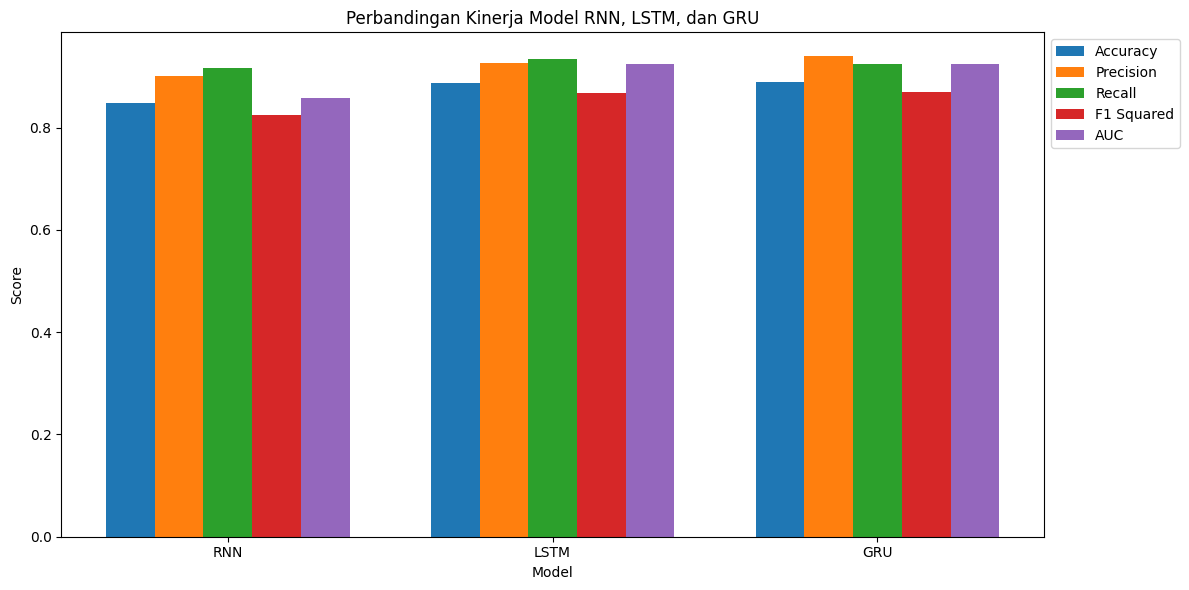

In [25]:
# Visualisasi perbandingan model
plt.figure(figsize=(12, 6))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Squared', 'AUC']
x = np.arange(len(models))
width = 0.15
multiplier = 0

for metric in metrics_to_plot:
    offset = width * multiplier
    plt.bar(x + offset, comparison_df[metric], width, label=metric)
    multiplier += 1

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Perbandingan Kinerja Model RNN, LSTM, dan GRU')
plt.xticks(x + width * 2, models)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()